<a href="https://colab.research.google.com/github/dsanroman96/Machine-Learning-Projects/blob/main/Neural_Network_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Imports**

In [ ]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from dnn_app_utils_v2 import *
import math
import sys

## **Layer**

In [ ]:
class Layers: 
    def __init__(self, composition):
        self.parameters = {}
        self.activation_functions = {}
        self.dimensions = []
        
        np.random.seed(2)
        
        for i in range(len(composition)):
            self.dimensions.append(composition[i][0])
            if i > 0:
                self.activation_functions[i] = composition[i][1]
        
        for l in range(1, len(self.dimensions)):
            self.parameters["W" + str(l)] = np.random.randn(self.dimensions[l], self.dimensions[l-1]) * np.sqrt(2/self.dimensions[l-1])
            self.parameters["b" + str(l)] = np.zeros([self.dimensions[l], 1])
        
        #print(self.parameters["W1"])
        

## **Forward Propagation**

In [ ]:
class Forward_Propagation:
    def forward(self, A, W, b):
        Z = np.dot(W, A) + b
        
        cache = (A, W, b)
        
        return Z, cache

    def activation_forward(self, A_prev, W, b, activation_function):
        Z, linear_cache = self.forward(A_prev, W, b)
        A = Activation_Function(activation_function, False).activate(Z, None)
        cache = (linear_cache, Z)

        return A, cache
    
    
    
    def run(self, X, parameters, activation_functions):
        caches = []
        activation_functions = activation_functions
        A = X
        L = len(parameters) // 2
        
        parameters[parameters == np.nan] = 1.e-17
        
        for l in range(1, L):
            A_prev = A
            A, Z = self.activation_forward(A_prev, parameters["W" + str(l)], parameters["b" + str(l)], activation_functions[l])
            caches.append(Z)
            

        AL, Z = self.activation_forward(A, parameters["W" + str(L)], parameters["b" + str(L)], activation_functions[L])
        caches.append(Z)
        
        
        return AL, caches

## **Functions**

### Activation Functions

In [ ]:
class Activation_Function:
    def __init__(self, name, back_prop):
        self.name = name
        self.back_prop = back_prop
        
    def sigmoid(self, Z, dA):
        if self.back_prop == True:
            s = 1/(1+np.exp(-Z))
            dZ = dA * s * (1-s)
            return dZ
        
        else:
            return 1/(1 + np.exp(-Z))
    
    
    def relu(self, Z, dA):
        if self.back_prop == True:
            dZ = np.array(dA, copy=True)
            dZ[Z <= 0] = 0
            return dZ
        else:
            return np.maximum(Z, 0)
    
    
    def tanh(self, Z, dA):
        if self.back_prop == True:
            return 1 / np.cosh(dA)**2
        else:
            activate = np.tanh(Z)    
            if np.isnan(np.sum(activate)).any():
                activate = np.zeros(activate.shape)
            return activate
    
    
    def activate(self, Z, dA):
        activation = None
        if self.name == "sigmoid":
            activation = self.sigmoid(Z, dA)
        
        elif self.name == "relu":
            activation = self.relu(Z, dA)
        
        elif self.name == "tanh":
            activation = self.tanh(Z, dA)
            
        
        return activation
        

### Cost Functions

In [ ]:
class Cost_Function:
    def __init__(self, name, back_prop):
        self.name = name
        self.back_prop = back_prop
    
    
    def mean_absolute_error(self, AL, Y):
        m = Y.shape[1]
        return np.sum(AL - Y) / m
    
    
    def root_mean_squared_error(self, AL, Y):
        m = Y.shape[1]
        return np.sqrt(self.mean_squared_error(AL, Y))
    
    
    
    def mean_squared_error(self, AL, Y):
        m = Y.shape[1]
        if self.back_prop:
            dA = Y - AL
            dA = -2 * dA/m
            
            return dA
        
        else:
            dA = np.sum(Y - AL)
            dA = dA**2
            dA = dA/m
            return dA
    
    
    def binary_cross_entropy(self, AL, Y):
        m = Y.shape[1]
        
        if self.back_prop == True:
            dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
            return dAL
        
        else:
            logprobs = np.multiply(np.log(AL),Y) + np.multiply(np.log(1 - AL), (1 - Y))
            cost = -np.sum(logprobs) / m
            return np.squeeze(cost)

        
        
    def compute_cost(self, AL, Y):
        cost = None
        
        if self.name == "mea" or self.name == "mean absolute error":
            cost = self.mean_absolute_error(AL, Y)
        
        if self.name == "mse" or self.name == "mean squared error":
            cost = self.mean_squared_error(AL, Y)
        
        if self.name == "rmse" or self.name == "root mean squared error":
            cost = self.root_mean_squared_error(AL, Y)
        
        if self.name == "bicren" or self.name =="binary cross entropy":
            cost = self.binary_cross_entropy(AL, Y)
        
        
        return cost


### Optimization

In [ ]:
class Optimization:
    def l2_regularization(self, parameters, lambd, m):
        L = len(parameters) // 2
        w_sum = 0
        for l in range(L):
            w_sum = w_sum + np.sum(parameters["W" + str(l + 1)])
        
        L2_regularization_cost = 1/m * lambd/2 * w_sum
        
        return L2_regularization_cost
            
        

## **Backpropagation**

In [ ]:
class Backpropagation:
    def __init__(self, l2_regularization, lambd):
        self.l2_regularization = l2_regularization
        self.lambd = lambd
        
        
    def backward(self, dZ, cache):
        A_prev, W, b = cache

        m = A_prev.shape[1]
        
        dW = np.dot(dZ, A_prev.T)/m
            
        if self.l2_regularization: 
            dW = (dW + (self.lambd/m * W)) + 1.e-17
            
        db = np.sum(dZ, axis=1, keepdims=True)
        dA_prev = np.dot(W.T, dZ)

        return dA_prev, dW, db
    
    
    def activation_backward(self, dA, cache, activation_function):
        linear_cache, activation_cache = cache
        dZ = Activation_Function(activation_function, True).activate(activation_cache, dA)
        dA_prev, dW, db = self.backward(dZ, linear_cache)

        return dA_prev, dW, db
    
    
    def run(self, AL, Y, caches, activation_functions, cost_function):
        grads = {}
        L = len(caches)
        m = AL.shape[1]
        Y = Y.reshape(AL.shape)
        
        dAL = Cost_Function(cost_function, True).compute_cost(AL, Y)

        current_cache = caches[L-1]
        
        grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = self.activation_backward(dAL, current_cache, activation_functions[L])       
        
        
        for l in reversed(range(L - 1)):
            current_cache = caches[l]
            dA_prev_temp, dW_temp, db_temp = self.activation_backward(grads["dA" + str(l + 1)], current_cache, activation_functions[l + 1])
            grads["dA" + str(l)] = dA_prev_temp
            grads["dW" + str(l + 1)] = dW_temp
            grads["db" + str(l + 1)] = db_temp
                

        return grads


## **Model**

In [ ]:
class Model: 
    def __init__(self, x_train=None, y_train=None, layers_composition=None, learning_rate=None, num_iterations=None, cost_function="bicren", 
                print_cost=False, print_cost_graphic=False, l2_regularization=False, lambd=0.01):
        
        self.layers = Layers(layers_composition)
        self.parameters = self.layers.parameters
        self.activation_functions = self.layers.activation_functions
        self.X = x_train
        self.Y = y_train
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.print_cost = print_cost
        self.print_cost_graphic = print_cost_graphic
        self.costs = []
        self.l2_regularization = l2_regularization
        self.lambd = lambd
        self.cost_function = cost_function
    
    
    def cost_graphic(self):
        plt.plot(np.squeeze(self.costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per hundreds)')
        plt.title("Learning rate =" + str(self.learning_rate))
        plt.show()
    
    
    def update_parameters(self, grads):
        L = len(self.parameters) // 2
        for l in range(L):
            self.parameters["W" + str(l + 1)] = self.parameters["W" + str(l + 1)] - self.learning_rate * grads["dW" + str(l + 1)]
            self.parameters["b" + str(l + 1)] = self.parameters["b" + str(l + 1)] - self.learning_rate * grads["db" + str(l + 1)]
            
            

            
    def run(self):
        for i in range(0, self.num_iterations):
            
            AL, caches = Forward_Propagation().run(self.X, self.parameters, self.activation_functions)
            
            cost = Cost_Function(self.cost_function, False).compute_cost(AL, self.Y)
            
            if self.l2_regularization: 
                cost + Optimization().l2_regularization(self.parameters, self.lambd, self.Y.shape[1])
            
            
            grads = Backpropagation(self.l2_regularization, self.lambd).run(AL, self.Y, caches, self.activation_functions, self.cost_function)
            
            self.update_parameters(grads)
            
            if self.print_cost and i % 100 == 0:
                print("Cost after iteration %i: %f" %(i, cost))

                
            if self.print_cost and i % 10 == 0:
                self.costs.append(cost)
            
        if self.print_cost_graphic:
            self.cost_graphic()
            

In [ ]:
def prediction(parameters, X, activation_functions):
    A2, cache = Forward_Propagation().run(X, parameters, activation_functions)
    predictions = (A2 > 0.5)
    
    return predictions

## Tests

In [ ]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()


# Mirroring Images
# -------------------------------------------
print(train_x_orig.shape)
print(train_y.shape)
print("")

x = []
y = []
for i in range(int(len(train_x_orig))):
    if i%5 == 0:
        inverse = np.fliplr(train_x_orig[i])
        x.append(inverse)
        y.append(train_y[0][i])

    
    x.append(train_x_orig[i])
    y.append(train_y[0][i])
    

train_x_orig = np.array(x)
train_y = np.array([y])
print(train_x_orig.shape)
print(train_y.shape)
print("")
# -------------------------------------------


# Reshape the training and test examples 
# -------------------------------------------
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T
# -------------------------------------------



# Standardize data to have feature values between 0 and 1.
# -------------------------------------------
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.
# -------------------------------------------


# Shuffle Data
# -------------------------------------------
print(train_x.shape)
print(test_x.shape)
print(len(train_x.T))
print(len(train_y.T))

shuffler = np.random.permutation(len(train_x.T))

train_x = train_x.T[shuffler]
train_x = train_x.T

train_y = train_y.T[shuffler]
train_y = train_y.T
# -------------------------------------------


mini_batch = []
x_len = (len(train_x))
print(x_len)
    
    

(209, 64, 64, 3)
(1, 209)

(251, 64, 64, 3)
(1, 251)

(12288, 251)
(12288, 50)
251
251
12288


Cost after iteration 0: 0.789988
Cost after iteration 100: 0.630673
Cost after iteration 200: 0.628569
Cost after iteration 300: 0.624969
Cost after iteration 400: 0.617525
Cost after iteration 500: 0.602459
Cost after iteration 600: 0.575256
Cost after iteration 700: 0.528529
Cost after iteration 800: 0.477556
Cost after iteration 900: 0.483513
Cost after iteration 1000: 0.439682
Cost after iteration 1100: 0.394940
Cost after iteration 1200: 0.332386
Cost after iteration 1300: 0.263695
Cost after iteration 1400: 0.151890
Cost after iteration 1500: 0.903104
Cost after iteration 1600: 0.107907
Cost after iteration 1700: 0.076589
Cost after iteration 1800: 0.070286
Cost after iteration 1900: 0.094465
Cost after iteration 2000: 0.075568
Cost after iteration 2100: 0.023967
Cost after iteration 2200: 0.018405
Cost after iteration 2300: 0.014696
Cost after iteration 2400: 0.012147


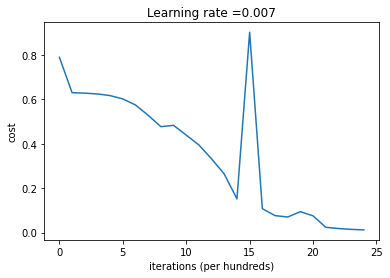


Accuracy Training: 100%
Accuracy Test: 68%


In [ ]:
m = Model(
    x_train = train_x,
    y_train = train_y,
    layers_composition = [[12288], [10, "relu"], [15, "relu"], [2, "relu"],  [1, "sigmoid"]],
    learning_rate = 0.007,
    num_iterations = 2500,
    print_cost = True,
    cost_function = "bicren",
    print_cost_graphic = True,
    l2_regularization = True,
    lambd = 0.8
)
m.run()

predictions1 = prediction(m.parameters, train_x, m.activation_functions)
predictions2 = prediction(m.parameters, test_x, m.activation_functions)
print("")
print ('Accuracy Training: %d' % float((np.dot(train_y,predictions1.T) + np.dot(1-train_y,1-predictions1.T))/float(train_y.size)*100) + '%')
print ('Accuracy Test: %d' % float((np.dot(test_y,predictions2.T) + np.dot(1-test_y,1-predictions2.T))/float(test_y.size)*100) + '%')

Cost after iteration 0: 0.674000
Cost after iteration 100: 0.601667
Cost after iteration 200: 0.687801
Cost after iteration 300: 0.413775
Cost after iteration 400: 0.543693
Cost after iteration 500: 0.451977
Cost after iteration 600: 0.209930
Cost after iteration 700: 0.130247
Cost after iteration 800: 0.092240
Cost after iteration 900: 0.066530
Cost after iteration 1000: 0.048608
Cost after iteration 1100: 0.037232
Cost after iteration 1200: 0.029144
Cost after iteration 1300: 0.022367
Cost after iteration 1400: 0.018032
Cost after iteration 1500: 0.015001
Cost after iteration 1600: 0.012508
Cost after iteration 1700: 0.010755
Cost after iteration 1800: 0.009432
Cost after iteration 1900: 0.008376


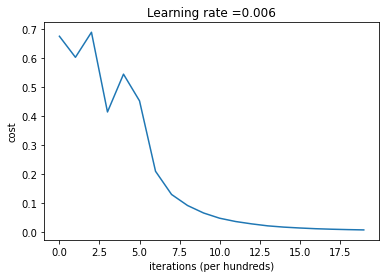


Accuracy Training: 100%
Accuracy Test: 68%


In [ ]:
m = Model(
    x_train = train_x,
    y_train = train_y,
    layers_composition = [[12288], [10, "relu"], [15, "relu"],[5, "relu"], [2, "relu"],  [1, "sigmoid"]],
    learning_rate = 0.006,
    num_iterations = 2000,
    print_cost = True,
    cost_function = "bicren",
    print_cost_graphic = True,
    l2_regularization = True,
    lambd = 0.8
)
m.run()

predictions1 = prediction(m.parameters, train_x, m.activation_functions)
predictions2 = prediction(m.parameters, test_x, m.activation_functions)
print("")
print ('Accuracy Training: %d' % float((np.dot(train_y,predictions1.T) + np.dot(1-train_y,1-predictions1.T))/float(train_y.size)*100) + '%')
print ('Accuracy Test: %d' % float((np.dot(test_y,predictions2.T) + np.dot(1-test_y,1-predictions2.T))/float(test_y.size)*100) + '%')